# Avance 1: Análisis exploratorio y preprocesamiento de datos

## Análisis exploratorio


A continuación, se cargan las librerias necesarias para el trabajo a realizar:

In [1]:
import json
import re
import csv
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

Se carga nuestro conjunto de datos, que como se puede observar se encuentra en formato JSON, y posteriormente se visualiza:

In [0]:
with open('arxivData.json') as f:
  data=json.load(f)

Se puede notar del conjunto de datos que se tienen 9 atributos en los cuales se caracterizan las dimensiones de nuestros datos:

In [3]:
df=pd.DataFrame.from_dict(json_normalize(data))
df.rename(columns={'id':'paper_id','summary':'abstract'},inplace=True)
df.tail(5)

,author,day,paper_id,link,month,abstract,tag,title,year
40995,"[{'name': 'Vitaly Feldman'}, {'name': 'Pravesh...",18,1404.4702v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,We study the complexity of learning and approx...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Nearly Tight Bounds on $\ell_1$ Approximation ...,2014
40996,"[{'name': 'Orly Avner'}, {'name': 'Shie Mannor'}]",22,1404.5421v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,We consider the problem of multiple users targ...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Concurrent bandits and cognitive radio networks,2014
40997,"[{'name': 'Ran Zhao'}, {'name': 'Deanna Needel...",22,1404.5899v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,"In this paper, we compare and analyze clusteri...","[{'term': 'math.NA', 'scheme': 'http://arxiv.o...",A Comparison of Clustering and Missing Data Me...,2014
40998,"[{'name': 'Zongyan Huang'}, {'name': 'Matthew ...",25,1404.6369v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",4,Cylindrical algebraic decomposition(CAD) is a ...,"[{'term': 'cs.SC', 'scheme': 'http://arxiv.org...",Applying machine learning to the problem of ch...,2014
40999,"[{'name': 'Imen Trabelsi'}, {'name': 'Dorra Be...",27,1407.0380v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,Several speaker identification systems are giv...,"[{'term': 'cs.SD', 'scheme': 'http://arxiv.org...",A Multi Level Data Fusion Approach for Speaker...,2014


In [4]:
dfdr=df.drop(["link","author","tag","day","month","year"],axis=1)
cols = dfdr.columns.tolist()
cols = cols[-3:] + cols[:-3]
dfdr = dfdr[cols]
dfdr.head(5)

,paper_id,abstract,title
0,1802.00209v1,We propose an architecture for VQA which utili...,Dual Recurrent Attention Units for Visual Ques...
1,1603.03827v1,Recent approaches based on artificial neural n...,Sequential Short-Text Classification with Recu...
2,1606.00776v2,We introduce the multiresolution recurrent neu...,Multiresolution Recurrent Neural Networks: An ...
3,1705.08142v2,Multi-task learning is motivated by the observ...,Learning what to share between loosely related...
4,1709.02349v2,We present MILABOT: a deep reinforcement learn...,A Deep Reinforcement Learning Chatbot


In [5]:
df.shape

(41000, 9)

In [6]:
dfdr.shape

(41000, 3)

Se quiere ver el porcentaje de datos faltantes en nuestro conjunto de datos, y claramente se observa que no hacen falta datos de los que se recolectaron por cada uno de los objetos.

Luego de esto se observa el tipo de dato que tenemos en cada uno de los atributos.

In [7]:
## porcentaje de datos faltantes por columna en df
dfdr.isnull().mean().sort_values(ascending=False)

title       0.0
abstract    0.0
paper_id    0.0
dtype: float64

In [8]:
## Tipos de datos en cada columna de df
dfdr.dtypes

paper_id    object
abstract    object
title       object
dtype: object

## Pre-procesamiento

Como nuestro objeto de estudio es el abstract, se quiere ver como influye este en la clasificación de nuestros artículos, para esto, debemos darle un tratamiento de tal manera que se pueda interpretar de manera más sencilla, un primer paso, es eliminar todos los signos de puntuación que esten presente en el, esto debido a que estamos interesados únicamente en las palabras claves más recurrentes que podamos encontrar. Una vez hecho esto, se muestra el resultado del abstract sin sus signos de puntuación.



In [0]:
def remove_punctuation(text):
  no_punt = "".join([c for c in text if c not in string.punctuation])
  return no_punt

In [10]:
#Quitar puntuación en abstracts
dfnopunt=dfdr
dfnopunt['abstract'] = dfnopunt['abstract'].apply(lambda x: remove_punctuation(x))
abstr=dfnopunt['abstract']
abstr.head(5)

0    We propose an architecture for VQA which utili...
1    Recent approaches based on artificial neural n...
2    We introduce the multiresolution recurrent neu...
3    Multitask learning is motivated by the observa...
4    We present MILABOT a deep reinforcement learni...
Name: abstract, dtype: object

En este caso, nuestro conjunto de datos no presenta palabras clave, por lo que se quiere hacer un estudio de todas aquellas palabras más frecuentes en los abstract y aquellas que no son tan fecuentes, para poder capturar quellas que sean realmente relevantes en nuestro estudio.

In [11]:
#Identify common words
freq = pd.Series(' '.join(abstr).split()).value_counts()[:20]
freq

the     318622
of      225982
and     163768
a       159314
to      144855
in       99063
is       85309
for      74793
that     69598
on       58946
we       50401
with     47114
We       46331
are      41910
this     40480
as       38788
by       36049
The      35943
an       34094
from     29325
dtype: int64

In [12]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(abstr).split()).value_counts()[-20:]
freq1

physicianidentified    1
GriponBerrou           1
trafic                 1
fXto                   1
scab                   1
textitAutoExtend       1
DVFs                   1
explanability          1
PCI1710                1
8315                   1
agrovision             1
6591                   1
Sentimental            1
Freight                1
frivolous              1
paralinguistics        1
wordlemma              1
DICOD                  1
noiseerror             1
ized                   1
dtype: int64

Otro aspecto importante a tener en cuenta es que hay palabras que no son relevantes a la hora de tratar de buscar nuestras palabras claves, estas palabras las denominaremos como Stop_words, y el tratamiento que les daremos es eliminarlas y únicamente trabajar con aquellas que me puedan dar información más relevante del artículo, obteniendo así vector con palabras por cada abstract.

In [0]:
def text_process(mess):
    nopunc=[char for char in mess if char not in string.punctuation]
    
    nopunc=''.join(nopunc)
    
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english') ]

In [14]:
abstract=dfdr['abstract'].apply(text_process)
abstract.head(5)

0    [propose, architecture, VQA, utilizes, recurre...
1    [Recent, approaches, based, artificial, neural...
2    [introduce, multiresolution, recurrent, neural...
3    [Multitask, learning, motivated, observation, ...
4    [present, MILABOT, deep, reinforcement, learni...
Name: abstract, dtype: object

In [0]:
dfdr['year']=abstract.apply(len)
dfdr.rename(columns={'year':'abstract_length'},inplace=True)

In [0]:
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["using", "show", "result", "large", "also", "iv", "one", "two", "new", "previously", "shown"]
stop_words = stop_words.union(new_words)

In [0]:
corpus = []
for i in range(0, 41000):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', abstr[i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [18]:
corpus[1]

'recent approach based artificial neural network anns promising result shorttext classification however many short text occur sequence eg sentence document utterance dialog existing annbased system leverage preceding short text classifying subsequent work present model based recurrent neural network convolutional neural network incorporates preceding short text model achieves stateoftheart result three different datasets dialog act prediction'

Visualizamos aquellas palabras mas mencionadas en todos los abstract, dando así una idea de los temas centrales de los artículos de investigación.

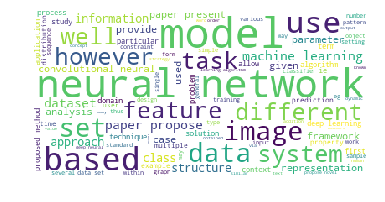

In [19]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
for i in range(0,41000):
  dfdr['abstract'][i]=corpus[i]
dfdr.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: ignored

In [21]:
dfdr.describe()

,abstract_length
count,41000.000000
mean,92.705195
std,32.905281
min,2.000000
25%,69.000000
50%,90.000000
75%,114.000000
max,312.000000


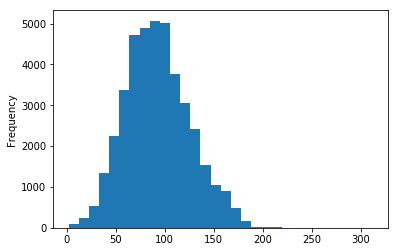

In [22]:
dfdr['abstract_length'].plot.hist(bins=30)

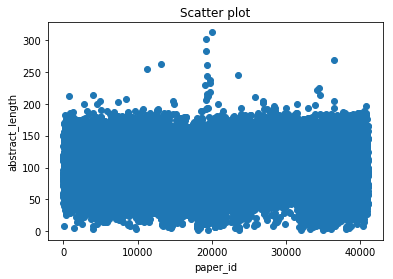

In [23]:
plt.scatter(dfdr.index, dfdr['abstract_length'])
plt.title('Scatter plot')
plt.xlabel('paper_id')
plt.ylabel('abstract_length')
plt.show()